# DSCI 521 Group project (Summer 21/22)

### Project submission group
- Group member 1
    - Name: Josh Clark
    - Email: jc4577@drexel.edu

## Introduction

Natural Language Processing has come a long way in the past few decades. Something that was once science fiction and seemed impossible 20 years ago is now present for free in any smartphone through Google, Siri, or Cortana if you're one of the few that actually bought a Windows phone. We can talk to a machine and it can break down our voice, derive meaning from our sentences, and execute commands or answer questions. We can search the web with a question written in plain text and get meaningful answers and websites returned to us. It has helped advance civilization and helped countless industries. However, despite being able to extract meaning and information from text, one thing that machines are notoriously bad at (even in science fiction) is understanding emotion and sentiment.

If computers could infer emotion and sentiment from text, through the use of some API for example, there could be a broad array of applications for it. A few of them include:
* **Monitoring social media for hate speech, bigotry, and discrimination automatically.** The internet is plagued with bullying and arguing and it frequently becomes a problem on many platforms to have enough manpower to moderate things. In most situations, the fact that it can't be adequately controlled actually acts to encourage it. The internet is a no man's land of free speech, and that can sometimes be taken advantage of for illegitimate reasons by those who oppress others.
* **Detecting mental health issues and self harm (or a desire to hurt others) in social media posts, messaging apps, and YouTube videos.** Mental health issues have been on the rise in recent years and most of it can go undetected by humans when someone appears to be normal. Identifying high risk scenarios quickly, such as when someone chooses to take their own life or the lives of others, is vital in preventing these unfortunate disasters, and many come with indications and red flags beforehand that are only noticed later. Being able to detect emotional outcries, such as one last goodbye message to a loved one, or subtle regular trends, such as melancholy daily Facebook posts, can also help programs to assist with those who feel neglected or are secretly crying for help.
* **Prioritizing customer complaints and product reviews.** One application that may secure more funding for this technology by big industries does actually have many positive impacts beyond simple money making. Although many people make wild accusations and big shows when the product they bought doesn't meet their expectations, and these issues do certainly need to be addressed, identifying unusually intense complaints, by both quantity and severity, is most important.

These are all scenarios where human involvement is necessary, but machines, just like they have always done, allow us to cover more ground by automating simple tasks and simplifying larger ones. Many of these problems can be addressed by extracting simple facts from text, such as what the problem is, but identifying the severity of the problem from the choice of wording can aid in prioritizing solutions and knowing which problems affect people in different ways. Not every complaint is out of anger. Some are out of fear or worry, and others are because of surprise or sadness. Positive sentiments, such as happiness and love, are important as well for many of the same reasons.

This project serves to demonstrate that emotions and sentiment can be learned given the proper data much the same as simpler positive/negative connotation can traditionally. The dataset we'll be using is called "Emotion Detection from Text" and contains exactly 40,000 Twitter posts with labels for 13 different sentiments that will be used as the target class. The words that make up each tweet, once sanitized, will be used as our features. We can leverage this with a Logistic Regression model to try to predict, given a 2/3 portioned training set, if we can predict the sentiment of unseen tweets in the remaining 1/3 testing set.

The dataset itself can be found on Kaggle.com here:
https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text

## My approach

The very first thing we need to do is read in the dataset and look at it. Let's create a function that will let us reload the dataset without having to specify the filename, and take a look at what it contains.

In [73]:
import pandas as pd

def loadDataset():
  return pd.read_csv('./data/tweet_emotions.csv', delimiter=',')

TwitterDataset = loadDataset()
print(TwitterDataset[:10])
print(f"Dataset size:{TwitterDataset.shape}")

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
5  1956968477       worry  Re-pinging @ghostridah14: why didn't you go to...
6  1956968487     sadness  I should be sleep, but im not! thinking about ...
7  1956968636       worry               Hmmm. http://www.djhero.com/ is down
8  1956969035     sadness            @charviray Charlene my love. I miss you
9  1956969172     sadness         @kelcouch I'm sorry  at least it's Friday?
Dataset size:(40000, 3)


It looks like we have 40,000 tweets, as promised, with columns for the tweet ID (which we won't need), the sentiment for the tweet, and the actual text. As to be expected with social media posts, there is a lot of misspelling, texting slang, and other variables like Twitter handles, URLs, and punctuation that will cause a lot of issues when extracting the actual words. We will deal with that in a moment, but first let's see how many tweets we have for each sentiment.

In [74]:
# Value counts of emotions
TwitterDataset['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Looks like some emotions such as "neutral" and "worry" have a lot of tweets, but other emotions like "boredom" and "anger" barely have any. Let's try to visualize the distribution better with a bar graph.

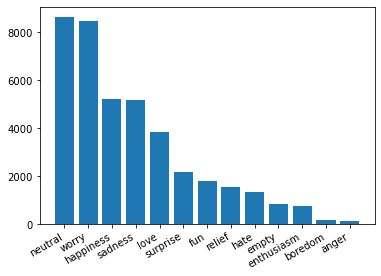

In [75]:
from matplotlib import pyplot as plt

def graphValueCounts(dataset):
  valueCounts = dataset.value_counts()
  fig, ax = plt.subplots()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  _ = plt.bar(valueCounts.index, valueCounts)

graphValueCounts(TwitterDataset['sentiment'])

Yes, it looks like there is quite a difference in representation for the different sentiments. We will need to address this so that this imbalance doesn't affect our classifier.

## Usefulness of sentiments and class imbalance

The ability for an ML model to "understand" a particular class comes from how much data you give it to represent the class. Often with imbalanced datasets, class labels with many samples tend to perform very well, with both precision and recall. Labels with fewer samples, however, are _less_ understood and there may be reasonably high precision, which is the ability to correctly identify when a sample _does_ have this label, but poor recall, which is the ability to correctly identify when a sample _does not_ have this label. This is because a lower sample count also means a lower count for each feature, which in turn causes a compounding error on the overall label prediction. The model has more information from the class prior, knowing how likely labels are to occur overall, and not as much information on what constitutes minority labels, which results in preferring majority labels when it is "less confident" in its prediction.

This data was likely collected with love vs hate, happiness vs sadness, worry vs relief, and fun vs boredom goals, but many of these simply don't have enough samples to work with and many aren't as interesting or "useful" for our investigation. Let's merge fun into happiness, and hate into anger since they describe very similar things. Let's also take out boredom, enthusiasm, relief, and empty because they're not as interesting and have low sample counts.

neutral      8638
worry        8459
happiness    6985
sadness      5165
love         3842
surprise     2187
anger        1433
Name: sentiment, dtype: int64


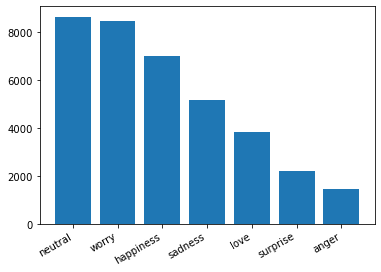

In [76]:
# Reload dataset so this cell can be run in succession
TwitterDataset = loadDataset()

# Drop the tweet_id column because we don't need it
TwitterDataset.drop('tweet_id', axis=1, inplace=True)

# Combine 'happiness' and 'fun' into just 'happiness'
TwitterDataset['sentiment'].replace(to_replace='fun', value='happiness', inplace = True)

# Combine 'anger' and 'hate' into just 'anger'
TwitterDataset['sentiment'].replace(to_replace='hate', value='anger', inplace = True)

# Remove 'boredom', 'enthusiasm', 'relief', and 'empty'
TwitterDataset = TwitterDataset[~TwitterDataset['sentiment'].isin(['boredom', 'enthusiasm', 'relief', 'empty'])]

# Reset index so that its ready to be filtered again
TwitterDataset.reset_index(drop=True, inplace=True)

# Show the exact count of each sentiment
print(TwitterDataset['sentiment'].value_counts())

# Display new reduced sentiment value counts
graphValueCounts(TwitterDataset['sentiment'])

This is better. There are less sentiments overall to worry about, but there is still an obvious imbalance that needs to be addressed. Although this will affect our final scores for these emotions, let's cap them all at 3000. This should give relatively equal representation without bringing them all down low like anger.

sadness      3000
worry        3000
love         3000
neutral      3000
happiness    3000
surprise     2187
anger        1433
Name: sentiment, dtype: int64


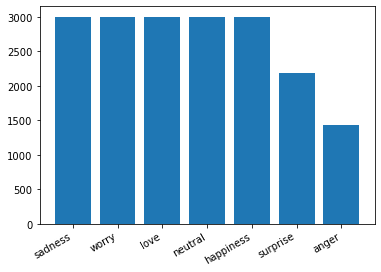

In [77]:
# Randomly select only 3k samples max from each sentiment
cap = 3000
combinedSamplesIndex = pd.Index([])
for sentiment in TwitterDataset['sentiment'].unique():
    # Grab the subset that has this sentiment
    sentimentSubset = TwitterDataset[TwitterDataset['sentiment'] == sentiment]
    # Grab cap random samples from this subset, or keep the old max if its already smaller
    cappedSubset = sentimentSubset.sample(n=min(cap, sentimentSubset.shape[0]), axis=0)
    # Take the indices of these samples from the original dataset and combine them
    combinedSamplesIndex = combinedSamplesIndex.union(cappedSubset.index)
# Now use these combined indices to reduce the dataset
TwitterDataset = TwitterDataset.iloc[combinedSamplesIndex]
# Reset the index again
TwitterDataset.reset_index(drop=True, inplace=True)

# Show the exact count of each now
print(TwitterDataset['sentiment'].value_counts())

# Display new capped sentiment value counts as a graph
graphValueCounts(TwitterDataset['sentiment'])

## Data cleaning

Now that we have a relatively even dataset, we will need to sanitize the input data by removing "nonsense words" from the tweet texts so that we are only working with meaningful words. Things like website URLs, Twitter handles, random numbers, punctuation, and emojis, and anything else that doesn't contribute adequate information need to be removed. All words will have to be forced to lowercase and punctuation inside or adjacent to words will be removed as well. Any texting slang will have to be reversed as much as possible to combine with correctly spelled out words. Unfortunately, misspelled words will have to be included, despite likely only appearing a few times each, because it will be near to impossible to remove or fix without some major processing and a database of correctly spelled words, or a specially built library which I was unable to find.

"Nonsense words", due to their extremely low likelihood of appearing more than once, and the fact that they rarely contribute much to the meaning of a sentence, act to confuse the classifier model by offering large amounts of useless information that drowns out features that are more representative of the tweet's emotion. Stopwords, such as "and" and "the", will also need to be removed for the same reason.

### Cleaning data in preparation for tokenization

First let's take another look at the dataset as is.

In [78]:
print(TwitterDataset[:10])

  sentiment                                            content
0   sadness  Layin n bed with a headache  ughhhh...waitin o...
1   sadness                Funeral ceremony...gloomy friday...
2     worry               Hmmm. http://www.djhero.com/ is down
3   sadness         @kelcouch I'm sorry  at least it's Friday?
4   sadness  Ugh! I have to beat this stupid song to get to...
5   sadness  @BrodyJenner if u watch the hills in london u ...
6  surprise                                       Got the news
7   sadness      The storm is here and the electricity is gone
8      love                               @annarosekerr agreed
9   sadness  How are YOU convinced that I have always wante...


You can see many previously mentioned examples of nonsense words all throughout these tweets. We can use regex to remove some of these, but we can also use the neattext library which simplifies some of the more complex regular expressions.

In [79]:
pip install neattext

Note: you may need to restart the kernel to use updated packages.


In [80]:
import re
import neattext as nt

# Remove "nonsense words" that shouldn't be included including usernames, punctuation, and stopwords
def cleanText(content):
    # Make everything lowercase
    content = content.lower()
    
    # Remove website URLs
    content = re.sub('((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-z0-9-_#]+\/?)*', ' ', content)

    # Remove ending punctuation and hyphens between words and separate with a space instead
    content = re.sub('(?<=\w)([\.!?,-]+)(?=\w+)',' ', content)
    
    # Remove twitter handles
    content = re.sub('(@\w+)', '', content)
    
    # Use neattext to automate some text cleaning
    tf = nt.TextFrame(content)
    tf.remove_urls()
    
    # Switch to normal regex to remove ending punctuation and hyphens between words
    content = tf.text
    content = re.sub('(?<=\w)([\.!?-]+)(?=\w+)','', content)
    
    # Switch back to neattext for the other functions
    tf = nt.TextFrame(content)
    tf.remove_emails()
    tf.remove_phone_numbers()
    tf.remove_numbers()
    tf.remove_emojis()
    tf.remove_stopwords()
    
    # Switch to regex to remove twitter handles
    content = tf.text
    content = re.sub('(@\w+)', '', content)
    
    # Use neattext again to remove punctuation
    tf = nt.TextFrame(content)
    tf.remove_special_characters()
    
    # Use regex to undo some texting slang to combine with correctly spelled words
    content = tf.text
    content = re.sub('(?<=\W)(u)(?=\W)', 'you', content)
    content = re.sub('(?<=\W)(bc)(?=\W)', 'because', content)
    content = re.sub('(?<=\W)(bf)(?=\W)', 'boyfriend', content)
    content = re.sub('(?<=\W)(gf)(?=\W)', 'girlfriend', content)
    content = re.sub('(?<=\W)(n)(?=\W)', 'and', content)
    content = re.sub('(?<=\W)(rn)(?=\W)', 'right now', content)
    content = re.sub('(?<=\W)(r)(?=\W)', 'are', content)
    content = re.sub('(?<=\W)(y)(?=\W)', 'why', content)
    content = re.sub('(?<=\W)(b)(?=\W)', 'be', content)
    content = re.sub('(?<=\W)(w)(?=\W)', 'with', content)
    
    # Remove successive whitespace
    content = re.sub('\s{2,}', ' ', content)
    
    return content

# Create a new object for the processed tweets and print the first 10
CleanDataset = TwitterDataset.copy()
CleanDataset['content'] = CleanDataset['content'].apply(cleanText)
print(CleanDataset[:10])

  sentiment                                            content
0   sadness          layin and bed headache ughhhh waitin call
1   sadness                     funeral ceremony gloomy friday
2     worry                                              hmmm 
3   sadness                                    im sorry friday
4   sadness                          ugh beat stupid song rude
5   sadness  u watch hills london you realise tourture week...
6  surprise                                           got news
7   sadness                             storm electricity gone
8      love                                             agreed
9   sadness  convinced wanted you signals damn think lost f...


This looks much better and is probably the best we can do given the original data. We can now tokenize these words per tweet and build a model.

## Building a statistical model

Before deriving a word count from these tweets, we need to split the dataset into a training set and a testing set. The training set will be used to build our stats for the classifier model, while the testing set will act as new unseen data that we can use to test the reliability of the model in practice.

In [81]:
# Split the data
CleanDataset_shuffled = CleanDataset.sample(frac=1).reset_index(drop=True)
splitIndex = int(2/3 * CleanDataset_shuffled.shape[0])
trainingSet = CleanDataset_shuffled[:splitIndex].reset_index(drop=True)
testingSet = CleanDataset_shuffled[splitIndex:].reset_index(drop=True)

# Display the two sets and their sizes
print(trainingSet)
print(testingSet)

       sentiment                                            content
0        sadness                           lip pierced minutes died
1           love                              love hair blowin wind
2      happiness  hahaha cartoon mascots go monster nice details...
3          worry  ss gym project finally finished damn filthy ho...
4           love                            happy mothers day moms 
...          ...                                                ...
12408       love                        lol good luck love vid ybwm
12409       love  wish enjoy drink outside beautiful evening nee...
12410    neutral                                   way santa monica
12411   surprise                   happy mothers day american mamas
12412   surprise          cheers tony btw notice swear words tweets

[12413 rows x 2 columns]
     sentiment                                            content
0        anger                        platypuses mammals lay eggs
1      sadness  sourish li

### Deriving word counts per sentiment

Now that we have good clean text, we can start adding up the count of each word for every sentiment that it occurs in. We are looking to create a numpy array with the unique words as rows and the sentiments as columns. Each cell in the matrix will be how many times that word occured in a tweet with that sentiment.

In [82]:
import numpy as np

# Get list of sentiments so we don't have to call this multiple times
sentiments = list(CleanDataset['sentiment'].unique())
# A list to keep track of all unique words
allWords_list = []
# A starting ndarray for our statistics
wordStats = np.empty((0,len(sentiments)), dtype=np.int64)
# A template for new rows
newRow = np.array([0 for sentiment in sentiments])

tweetWordCounts = []

# Go through all words in all tweets and add them up
for _, tweet in trainingSet.iterrows():
    tweetWordCounts.append(len(tweet['content'].split()))
    for word in tweet['content'].split():
        # New words get added to allWords and we add a row to wordStats
        if word not in allWords_list:
            allWords_list.append(word)
            wordStats = np.vstack((wordStats, newRow.copy()))
        # Get indices for the word and sentiment
        wordIndex = allWords_list.index(word)
        sentimentIndex = sentiments.index(tweet['sentiment'])
        # Increment that spot in the ndarray
        wordStats[wordIndex, sentimentIndex] += 1

# Make this an ndarray to make it compatible with wordStats, but keep the
# list form so we can use .index() to quickly find a particular word's location
allWords = np.array(allWords_list)

# Print out some stats
print(f"Total number of words: {allWords.shape[0]}")
print(f"Average tweet length in words: {np.mean(tweetWordCounts):.3f}")

# Print out first 10 words
print(f"First 10 words:")
print(allWords[:10])

# Print out stats for first 10 words
print(f"Sentiment counts for the first 10 words:")
print(wordStats[:10,:])

Total number of words: 15168
Average tweet length in words: 6.720
First 10 words:
['lip' 'pierced' 'minutes' 'died' 'love' 'hair' 'blowin' 'wind' 'hahaha'
 'cartoon']
Sentiment counts for the first 10 words:
[[  2   2   0   0   1   0   0]
 [  1   1   0   1   0   0   0]
 [  5  12   8   3   6   2   5]
 [ 12   8   4   3   2   1   0]
 [ 46  39  34 447  13  33  60]
 [ 11  12  19   8   5   5  12]
 [  0   0   0   1   0   0   1]
 [  1   0   1   2   0   3   1]
 [  3   3   9  10   3   6  18]
 [  0   0   0   0   1   0   1]]


This looks good. You can see that some words occur a lot more than others, such as "day", and some occur very infrequently, such as "route". This is the nature of the english language however, or any language actually, and is unavoidable except for extremely large datasets. Let's show some of the stats that we've gathered. Let's see what the top 10 words are for each sentiment and how many times they occur. Then we can see the top 10 words of any sentiment and how often they occur.

In [83]:
# Print the top 10 words for each sentiment
for sentiment in sentiments:
    # Get sorted indices for this sentiment
    sentimentIndex = sentiments.index(sentiment)
    # Get the indices of the descending sorted occurances of words for this sentiment
    wordCountIndices = wordStats[:,sentimentIndex].argsort()[::-1]
    
    print(f"Top 10 words for \"{sentiment}\" and their counts:")
    print(allWords[wordCountIndices][:10])
    print(wordStats[wordCountIndices,sentimentIndex][:10])
    print()

# Get total count for each word
totalWordCounts = wordStats.sum(axis=1)
wordCountIndices = totalWordCounts.argsort()[::-1]

print("Top 10 words for any sentiment and their counts:")
print(allWords[wordCountIndices][:10])
print(totalWordCounts[wordCountIndices][:10])

Top 10 words for "sadness" and their counts:
['im' 'sad' 'work' 'day' 'like' 'miss' 'today' 'cant' 'got' 'sorry']
[343 161 128 126 122 117 108 103  98  90]

Top 10 words for "worry" and their counts:
['im' 'like' 'today' 'day' 'cant' 'going' 'you' 'work' 'know' 'got']
[273 118 101 100  98  98  90  88  87  86]

Top 10 words for "surprise" and their counts:
['im' 'oh' 'you' 'day' 'got' 'like' 'going' 'know' 'good' 'cant']
[136  83  77  77  72  70  63  62  61  61]

Top 10 words for "love" and their counts:
['love' 'day' 'happy' 'mothers' 'im' 'you' 'good' 'thanks' 'like' 'lol']
[447 423 328 302 188 178 163 101  95  79]

Top 10 words for "anger" and their counts:
['hate' 'im' 'like' 'work' 'cant' 'sucks' 'got' 'good' 'want' 'day']
[138 106  70  60  49  48  44  38  36  34]

Top 10 words for "neutral" and their counts:
['im' 'day' 'like' 'you' 'work' 'good' 'know' 'going' 'today' 'time']
[157 113  88  81  80  73  63  62  61  53]

Top 10 words for "happiness" and their counts:
['im' 'day' 'go

One last step before we can use this in our classifier: we need to _normalize_ the array. Most classifiers, including the one we'll be using, treat each feature equally, so words that have a much higher count will affect the model more. We need to know instead just the _proportion_ of occurances across all sentiments for each word, so we'll divide by the sum of all occurances of each word.

In [84]:
# Turn this ndarray from discrete counts to a probability distribution for each word
wordStats_normalized = wordStats / wordStats.sum(axis=1)[:,np.newaxis]

# Show the final statistics model
print(wordStats_normalized)
print(wordStats_normalized.shape)

[[0.4        0.4        0.         ... 0.2        0.         0.        ]
 [0.33333333 0.33333333 0.         ... 0.         0.         0.        ]
 [0.12195122 0.29268293 0.19512195 ... 0.14634146 0.04878049 0.12195122]
 ...
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(15168, 7)


This will be useful for a Naive Bayes classifier, which unfortunately had to be cut for sake of time, but is one route we could take for further study.

### One hot encoding occurrances of words in each tweet

For Logistic Regression, we instead need to "one hot encode" the words in all tweets. This means we have to tally how many times a word appears in each tweet so that each tweet has a count for every known word. This will make a very large and sparse matrix of values where there are many 0s because there are many more unique words than there are words in each tweet, but we will be using sklearn which handles this efficiently. Before we do this however, we will need a function that filters the words in a tweet to only those that we know. We will simply tokenize the words in the string and only include those in our database of words. This is functionally equivalent to string.split() for the training set, but we will need this for the testing set so we do not try to index a word in new data that doesn't exist in our model.

In [85]:
# Tokenize a tweet, but only keep those words we know
def splitTweetIntoWords(tweetText):
    listOfWords = []
    for word in tweetText.split():
        if word in allWords_list:
            listOfWords.append(word)
    return listOfWords

# Test it
splitTweetIntoWords("god rest ye merry gentlemen")

['god', 'rest']

This works well! Depending on how we randomly selected the initial tweets earlier, some of these words may be included but likely some of them won't. Now we need to actually one hot encode words from a series of tweets into a sparse matrix. Since we now know the number of unique words in our dataset, we know the shape ahead of time and it should run much faster.

In [86]:
# One hot encode the words a series of tweets into an (nTweets,nAllWords) ndarray
def oneHotEncodeTweetWords(tweetSeries):
    # Instantiate output ndarray
    output = np.ndarray((tweetSeries.shape[0],allWords.shape[0]), dtype=np.int64)
    for tweetIndex, tweetText in enumerate(tweetSeries):
        # Count each word for this tweet
        for word in splitTweetIntoWords(tweetText):
            output[tweetIndex,allWords_list.index(word)] += 1
    return output

# Test this on the first 10 tweets in the training set
test = oneHotEncodeTweetWords(trainingSet['content'][:10])
print(test)
print(test.shape)

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(10, 15168)


Now that we have a function, all we have to do is run it on both our training set and our testing set!

In [87]:
from timeit import default_timer

# Create the x values for training. And just to be curious, see how long it takes
start = default_timer()
x_train = oneHotEncodeTweetWords(trainingSet['content'])
print(f"x_train completed in {default_timer()-start:.3f} seconds.")

# Do it again for the testing set
start = default_timer()
x_test = oneHotEncodeTweetWords(testingSet['content'])
print(f"x_test completed in {default_timer()-start:.3f} seconds.")

# y_train and y_test are much easier to make just converting straight to ndarray
y_train = trainingSet['sentiment'].to_numpy(copy=True)
y_test = testingSet['sentiment'].to_numpy(copy=True)

# Ensure that both wordStats and x_train have the same total number of words
print(f"total words in wordStats: {wordStats.sum()}")
print(f"total words in x_train: {x_train.sum()}")

x_train completed in 8.337 seconds.
x_test completed in 4.154 seconds.
total words in wordStats: 83416
total words in x_train: 83416


## Tweet text sentiment classification using logistic regression

Now is the moment we've been waiting for! We can finally build our machine learning model using logistic regression! We will use sklearn for this because it greatly simplifies things and condenses code for simple tasks like computing metrics. We will use the multinomial approach since we have multiclass data, and the "lbfgs" solver. We also need to increase the default max iterations of the gradient descent algorithm from a measely 100 to 10,000. We can then make some predictions on our training set, which should score fairly high given its what we built the model on, and the testing set, which might score a bit lower.

In [88]:
from sklearn.linear_model import LogisticRegression

# Create the model
classifier_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# Train the model
classifier_LR.fit(x_train, y_train)

# Make predictions on the training set
yhat_train_LR = classifier_LR.predict(x_train)
# Make predictions on the testing set
yhat_test_LR = classifier_LR.predict(x_test)

# Print out the first 10 actual and predicted sentiments for tweets in the training set
print(f"Actual training sentiments: {y_train[:10]}")
print(f"Predicted training sentiments: {yhat_train_LR[:10]}")
print()

# Do it again for the testing set
print(f"Actual testing sentiments: {y_test[:10]}")
print(f"Predicted testing sentiments: {yhat_test_LR[:10]}")

Actual training sentiments: ['sadness' 'love' 'happiness' 'worry' 'love' 'neutral' 'happiness' 'love'
 'happiness' 'love']
Predicted training sentiments: ['sadness' 'love' 'happiness' 'worry' 'love' 'neutral' 'anger' 'love'
 'neutral' 'love']

Actual testing sentiments: ['anger' 'sadness' 'neutral' 'neutral' 'anger' 'happiness' 'love'
 'neutral' 'anger' 'anger']
Predicted testing sentiments: ['surprise' 'love' 'neutral' 'neutral' 'anger' 'love' 'neutral' 'worry'
 'sadness' 'worry']


Now all our hard work is done and we can just observe what kind of stats we get from the output. Again, we will use sklearn for this.

In [89]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get metrics for the training set
accuracy_train_LR = accuracy_score(y_train, yhat_train_LR)
precision_train_LR, recall_train_LR, f1_train_LR, _ \
    = precision_recall_fscore_support(y_train, yhat_train_LR, average='macro', labels=sentiments)

# Get metrics for the testing set
accuracy_test_LR = accuracy_score(y_test, yhat_test_LR)
precision_test_LR, recall_test_LR, f1_test_LR, _ \
    = precision_recall_fscore_support(y_test, yhat_test_LR, average='macro', labels=sentiments)

# Print everything out
print("training set:")
print(f"accuracy: {accuracy_train_LR:.3f}")
print(f"precision: {precision_train_LR:.3f}")
print(f"recall: {recall_train_LR:.3f}")
print(f"f1 score: {f1_train_LR:.3f}")
print()
print("testing set:")
print(f"accuracy: {accuracy_test_LR:.3f}")
print(f"precision: {precision_test_LR:.3f}")
print(f"recall: {recall_test_LR:.3f}")
print(f"f1 score: {f1_test_LR:.3f}")

training set:
accuracy: 0.833
precision: 0.846
recall: 0.831
f1 score: 0.836

testing set:
accuracy: 0.332
precision: 0.335
recall: 0.320
f1 score: 0.323


## Conclusion

Although our model metrics did not score very high, this is to be expected given our starting data. Although 40,000 tweets sounds like a lot, we did have to cut a lot out to account for class imbalance, and we could only extract an average of about 6.8 "clean" words from each tweet from our training set. For a real world application for this, we will need a much larger dataset with not only a lot of labeled samples, but many words in each sample. Having very few words to go on makes each tweet very inaccurate, and because there are so many words in the English language, there are many many words we can run into in unseen data that are likely not in our database. We will need adequate sentiment classification for every word for probably 100,000 or more unique words, and test this on much longer strings of text that give us more to go on. However, this should show that it is quite possible to predict sentiment from raw text, and doing so not only expands what we can do with NLP, but also gives us greater insight to human emotion ourselves.

## Future work

Although this project did demonstrate how we can classify emotion, there are several ways how we can improve on this, or things we could have included in this project as listed below:

* Get more data for less common emotions
* Get better libraries for cleaning and processing raw text
* Try different types of classifiers such as Naive Bayes, Decision Trees, k Nearest Neighbors, or Support Vector Machines
* Experiment with custom Neural Networks
* Examine the effect of class imbalance on each sentiment
* Examine the use of Principal Component Analysis to detect the most meaningful words instead of relying on a library to filter out stop words
* Create more visuals to showcase the results that we find

## Works accredited

Josh Clark
* Everything